In [2]:
import os

from ruamel.yaml import YAML
import torch, pyro

from clipppy.patches import torch_numpy
from clipppy import load_config
from clipppy.helpers import scheduled_optimizer_callback_with_loss
from functools import partial

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:
import matplotlib.pyplot as plt
import collections

from plotting import plot_mult, test_import
test_import(1)

2

#### Plotting utilities

In [4]:
# import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from corner import corner


imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

def plot_fit_resids():
    pred = config.ppd()['model_trace'].nodes['mu']['value']

    if len(pred.shape) == 3 and pred.shape[0] == 1:
        pred = pred[0]

    err = (pred - OBS) / NOISE
    vm = err.abs().max()
    err[~MASK] = np.nan # setting all the values outside mask to nan

    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4))
    imshow_with_cbar(axs[0], OBS / NOISE, **imkwargs, vmin=0, vmax=30)
    imshow_with_cbar(axs[1], pred / NOISE, **imkwargs, vmin=0, vmax=30)
    imshow_with_cbar(axs[2], err, **imkwargs, cmap='bwr', vmin=-vm, vmax=vm)
    plt.tight_layout()


def imshow_with_cbar(ax, img, position='right', cbar_kwargs={}, **kwargs):
    im = ax.imshow(img, **kwargs)
    plt.colorbar(
        im,
        cax=make_axes_locatable(ax).append_axes(position, size='5%', pad=0.05),
        orientation='vertical' if position in ('left',
                                               'right') else 'horizontal',
        **cbar_kwargs)
    return im


def display_guide(params, guide=None, nsamples=1000, ppd=None, exclude=lambda name: False, **kwargs):

    if ppd is None:
        with pyro.plate('plate', nsamples):
            ppd = guide()
    if type(ppd) is tuple:
        ppd = ppd[1]
    ppd = {key: val for key, val in ppd.items() if not exclude(key)}
    names = [k.split('/', 1)[1] if '/' in k else k for k in ppd.keys()]
    truths = [params.get(k, None) for k in ppd.keys()]
    
    for (k, v), name, truth in zip(ppd.items(), names, truths): 
        print(f'{name:>7}: {v.mean():+.5f}±{v.std():.5f} ({truth}{v.mean()-truth:+f}: {abs((truth - v.mean()) / v.std()):.1f}-sigma)')
             
    return corner(np.transpose([v.flatten().numpy() for v in ppd.values()]),
                  labels=[f'{name}={truth:.3f}' for name, truth in zip(names, truths)],
                  truths=truths,
                  **kwargs)

def plot_source(gp):
    X_grid, Y_grid = get_meshgrid(0.003, 400, 400)
    p_grid = torch.stack((X_grid, Y_grid), -1).flatten(0, 1)
    Sigma_grid = gp._get_Sigma(X_grid, Y_grid).flatten(-2, -1).flatten(0, 1)

    imshow_kwargs = {'origin': 'lower', 'extent': [-0.6, 0.6, -0.6, 0.6]}

    gp_src_imgs = gp.flux(p_grid, Sigma_grid).reshape(*gp.batch_shape,
                                                      *X_grid.shape)

    fig, axes = plt.subplots(1, 5, figsize=(16, 4))

    imshow_with_cbar(axes[0], gp_src_imgs.sum(0).numpy(), **imshow_kwargs)

    for i, ax in enumerate(axes.flatten()[1:]):
        imshow_with_cbar(ax, gp_src_imgs[i].numpy(), **imshow_kwargs)
        ax.set_title(r"$\sigma = %f$" % gp.stochastic_specs['sigma'][i].item())

    fig.tight_layout()

    return fig, axes

# def plot_mult(plots, nrows = 1, colorbar = False, size_x = 16, size_y = 8):
    
#     ncols = len(plots) // nrows

#     fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x, size_y))
#     for ax, plot in zip(axes.flatten(), plots):
#         im = ax.imshow(plot)
#         if colorbar == True:
#             fig.colorbar(im, fraction=0.046, pad=0.04, ax = ax)
#     plt.tight_layout()
#     plt.show()

In [5]:
SYSTEM_NAME = "ngc4414"

os.makedirs(SYSTEM_NAME, exist_ok=True)
BASEDIR = os.path.join(SYSTEM_NAME)
os.makedirs(BASEDIR, exist_ok=True)

#### Load config

In [6]:
PARAMS = YAML().load(open('params.yaml'))[SYSTEM_NAME]

config = load_config('config_fit_lens.yaml', base_dir=BASEDIR)
model, guide = config.umodel, config.guide

OBS = config.conditioning['image']
MASK = config.kwargs['defs']['mask']
NOISE = model.stochastic_specs['sigma_stat']

OBS = torch.load(os.path.join(BASEDIR, 'OBS.pt'))
lens = torch.load(os.path.join(BASEDIR, 'lens.pt'))

TypeError: too many positional arguments

In [13]:
for i in PARAMS:
    print(i)
    print(PARAMS[i])
    print()

scale
1.0

truth
ordereddict([('ext/gamma_1', 0.007), ('ext/gamma_2', 0.01), ('main/phi', 1.0), ('main/q', 0.75), ('main/r_ein', 1.5), ('main/slope', 2.1), ('main/x', -0.05), ('main/y', 0.1), ('lenslight/x', 0.3), ('lenslight/y', 0.1), ('lenslight/phi', 0.0), ('lenslight/q', 1.0), ('lenslight/index', 1.0), ('lenslight/r_e', 1.0), ('lenslight/I_e', 5.0)])

init
ordereddict([('ext/gamma_1', 0.0), ('ext/gamma_2', 0.0), ('main/phi', 0.5), ('main/q', 0.5), ('main/r_ein', 1.42), ('main/slope', 2.0), ('main/x', 0.0), ('main/y', 0.0), ('lenslight/x', 0.0), ('lenslight/y', 0.0), ('lenslight/phi', 0.0), ('lenslight/q', 1.0), ('lenslight/index', 1.0), ('lenslight/r_e', 1.0), ('lenslight/I_e', 5.0)])



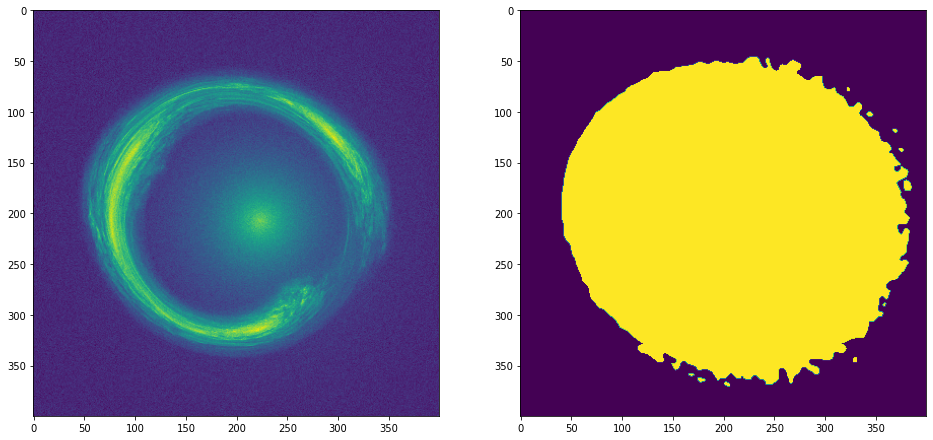

In [14]:
plots = [OBS + lens, MASK]
plot_mult(plots)

In [15]:
GUIDENAME_SP = os.path.join(BASEDIR, f'guide-{SYSTEM_NAME}-sp.pt')
GUIDENAME_SHALLOW = os.path.join(BASEDIR, f'guide-{SYSTEM_NAME}-shallow.pt')
GUIDENAME_FINAL = os.path.join(BASEDIR, f'guide-{SYSTEM_NAME}-final.pt')
LOSSESNAME = os.path.join(BASEDIR, f'losses-{SYSTEM_NAME}.pt')

LOSSESNAME_SP = os.path.join(BASEDIR, f'losses-{SYSTEM_NAME}-sp.pt')
LOSSESNAME_SHALLOW = os.path.join(BASEDIR, f'losses-{SYSTEM_NAME}-shallow.pt')
LOSSESNAME_FINAL = os.path.join(BASEDIR, f'losses-{SYSTEM_NAME}-final.pt')

In [16]:
for i in [GUIDENAME_SP, GUIDENAME_SHALLOW, GUIDENAME_FINAL, LOSSESNAME]:
    print(i)

ngc4414/guide-ngc4414-sp.pt
ngc4414/guide-ngc4414-shallow.pt
ngc4414/guide-ngc4414-final.pt
ngc4414/losses-ngc4414.pt


In [17]:
model.sources['src'] = config.kwargs['defs']['src']
model.sources['gp'] = config.kwargs['defs']['gp']

In [48]:
# print(model.sources)

# print(model.alphas)

# for lens in model.alphas.values():
#     print(lens.stochastic_specs)

In [18]:
from clipppy.stochastic import Sampler

# Set initial values # Instead of random value choose value close to truth value
for lens in model.alphas.values(): # looping over ext and main
    for spec in lens.stochastic_specs.values(): # looping over lens params
        if isinstance(spec, Sampler): # always returns true? # If we add other parameters to system, but don't have a init value
            name = lens.stochastic_name + '/' + spec.name
            if name in PARAMS['init']: # always returns true?
                spec.init = spec.infer['init'] = PARAMS['init'][name] # spec only lives in this for-loop, so what's the point? # spec is not begin set, but lens.stochastic_specs.values
                
# Fix slope to the truth
model.alphas['main'].stochastic_specs['slope'] = PARAMS['truth']['main/slope']

In `config_fit.yaml` are 4 guides, with the names: `gp_alpha`, `gp`, `src_alpha` and `g`. `alpha` stands for the normalization of the GP, it describes the heigth of the Gaussian.

1. `src_alpha` refers to `defs/src/alpha` in `config_fit.yaml`, with its `match: src/alpha`. It is just one number for one process. Therefore 1 site and 1 dim.

2. `gp_alpha` refers to `defs/gp/alpha` in `config_fit.yaml`, with its `match: gp/alpha`. It has one normalization for all three layers. Therefore 1 site and 3 dim.

3. `gp` refers to everything inside `defs/gp/` in `config_fit.yaml`, with its `match: gp/.*`. That is for:
* `defs/gp/theta`: all the dims, $\theta$ the values of the parameters of the GP, the values the GP will take.

    However, not for:

* `defs/gp/alpha`: one dim, $\alpha$ the normalization. Because Clipppy knows that `gp/alpha` is already taken into account by `gp_alpha`
* `defs/gp/sigma`: one dim, $\sigma$ the size of the kernel of the GP (width of the Gaussian. Sigma is being fixed with `geomspace`. Therefore it is not taken into account.


4. `g` refers to everything that is left, so `defs/src/theta` and `defs/model/alpha` in `config_fit.yaml` *without* its `match`. It takes all the lens and source plane parameters into account, and desribes the correlation between them. Takes all the diagonal $\theta$ parameters into account. All the leftover paramteers: lens and left sources, which are below it.
* sites: One site because of the theta parameters of the source plane, seven sites because of the lens parameters. (Not 8 because one lens parameter is fixed)
* dims: 7 (parameters) + 1600 (40x40 grid) = 1607

Correct way to do it: one guide for all the parameters, but that's practically impossible. At least correlate source plane parameters with lens plane.


In [50]:
guide.setup() # comes from config.yaml -> guide
guide

TypeError: __call__() missing 2 required positional arguments: 'X' and 'Y'

In [14]:
print( guide.gp.loc.shape)
print( guide.g.loc, guide.g.scale_diag.shape )
print( guide.g.scale_cross.shape, guide.g.scale_full.shape )

torch.Size([213651])
Parameter containing:
tensor([0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
       requires_grad=True) torch.Size([1600])
torch.Size([1600, 7]) torch.Size([7, 7])


# Initial fit (lens and source plane source)

Ultimate goal is to get $\mu$
* Sources (`gp` and `src`) are to contruct background source.
* $\alpha$ is to understand how it's being distorted to image, determined by lens params.

We have to deactive `gp` and `gp_alpha`, otherwise it would distord, it would be random. 

In [15]:
losses = []

# Remove image plane source and deactivate its guide
model.sources.pop('gp', None)
guide.gp_alpha.active = guide.gp.active = False # So gp_alpha and gp are (only) for the image plane, 
# How does one know that guide.[guide].active works like this?

In [16]:
if not os.path.isfile(GUIDENAME_SP):
    print('training')
    guide.train() # g and src_alpha are trained
    losses += config.fit(lr=1e-2, n_steps=50)#00)
    torch.save(guide, GUIDENAME_SP) 
    torch.save(losses, LOSSESNAME)
    torch.save(losses, LOSSESNAME_SP)
else:
    print('already trained!')

print(f'Length of `losses` = {len(losses)}')

already trained!
Length of `losses` = 0


In [17]:
print('Loading', GUIDENAME_SP)
guide_gp, guide_gp_alpha = guide.gp, guide.gp_alpha # What is the purpose of this?
guide = config.guide = torch.load(GUIDENAME_SP)
guide.gp, guide.gp_alpha = guide_gp, guide_gp_alpha # With this
# if os.path.exists(LOSSESNAME):
#     losses = torch.load(LOSSESNAME)
if os.path.exists(LOSSESNAME_SP):
    losses = torch.load(LOSSESNAME_SP)

print(f'Length of `losses` = {len(losses)}')

Loading ngc4414/guide-ngc4414-sp.pt
Length of `losses` = 50


# Shallow image plane source (fixed lens and source plane source)

For `ReduceLROnPlateau`, put `fit` from `experiments/paper-source/config.yaml` into `config`. Can also change `fit()`.

In [18]:
# Include image plane source and activate its guide
model.sources['gp'] = config.kwargs['defs']['gp']
guide.gp_alpha.active = guide.gp.active = True

In [19]:
if not os.path.isfile(GUIDENAME_SHALLOW):
    print('training')
    guide.eval()
    guide.gp.train(), guide.gp_alpha.train()

    losses += config.fit(lr=1e-2, n_steps=50)#00)
    torch.save(guide, GUIDENAME_SHALLOW)
    torch.save(losses, LOSSESNAME)
    torch.save(losses, LOSSESNAME_SHALLOW)
else:
    print('already trained!')

print('Loading', GUIDENAME_SHALLOW)
guide = config.guide = torch.load(GUIDENAME_SHALLOW)
# losses = torch.load(LOSSESNAME)
losses = torch.load(LOSSESNAME_SHALLOW)

print(f'Length of `losses` = {len(losses)}')

already trained!
Loading ngc4414/guide-ngc4414-shallow.pt
Length of `losses` = 100


In [20]:
# guide.eval() # not needed

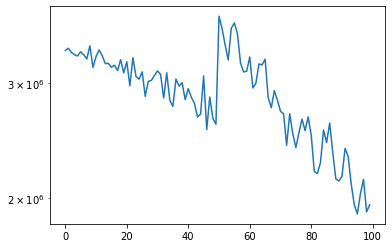

In [21]:
plt.plot(losses)
plt.yscale('log')

# Fit everything

In [22]:
if not os.path.isfile(GUIDENAME_FINAL):
    print('training')
    guide.train()
    losses += config.fit(lr=1e-3, n_steps=100, loss_args=dict(num_particles=1)) # was num_particles=4
    torch.save(losses, LOSSESNAME)
    torch.save(losses, LOSSESNAME_FINAL)
    torch.save(guide, GUIDENAME_FINAL)
else:
    print('already traied!')
    
print('Loading', GUIDENAME_FINAL)
guide = config.guide = torch.load(GUIDENAME_FINAL)
losses = torch.load(LOSSESNAME_FINAL)

print(f'Length of `losses` = {len(losses)}')

already traied!
Loading ngc4414/guide-ngc4414-final.pt
Length of `losses` = 200


In [23]:
# NTOTAL_STEPS = 20000 # was 30000
# if os.path.isfile(GUIDENAME_FINAL):
#     print('Loading', GUIDENAME_FINAL)
#     guide = config.guide = torch.load(GUIDENAME_FINAL)

# guide.train()
# while len(losses) < NTOTAL_STEPS:
#     losses += config.fit(lr=1e-3, n_steps=10000, loss_args=dict(num_particles=1)) # was num_particles=4
#     torch.save(losses, LOSSESNAME)
#     torch.save(losses, LOSSESNAME_FINAL)
#     torch.save(guide, GUIDENAME_FINAL)


In [24]:
# losses = torch.load(LOSSESNAME_FINAL)
# guide = config.guide = torch.load(GUIDENAME_FINAL)

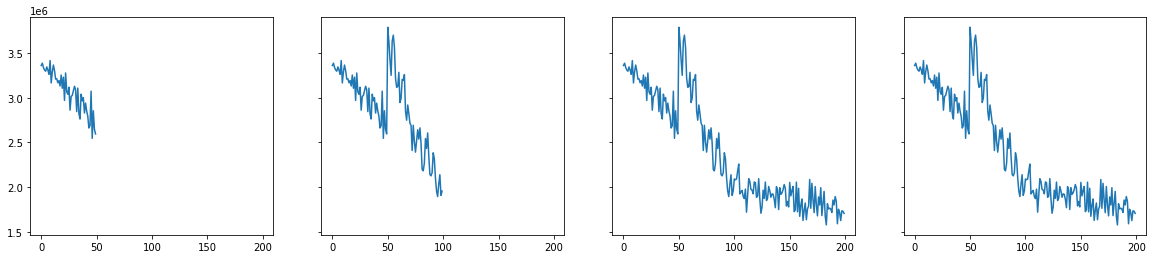

In [25]:
LOSSESNAMES = [LOSSESNAME_SP, LOSSESNAME_SHALLOW, LOSSESNAME_FINAL, LOSSESNAME]
losses_list = list(map(torch.load, LOSSESNAMES))
fig, axs = plt.subplots(1, len(losses_list), figsize = (20, 4), sharex = True, sharey = True)
for ax, i in zip(axs, range(len(losses_list))):
    ax.plot(losses_list[i])

---

### Plot

In [26]:
# losses = torch.load('ngc4414/old_guides_2/losses-ngc4414-final.pt')
# guide = config.guide = torch.load('ngc4414/old_guides_2/guide-ngc4414-final.pt')
# plt.plot(losses)

##### Fit and residuals

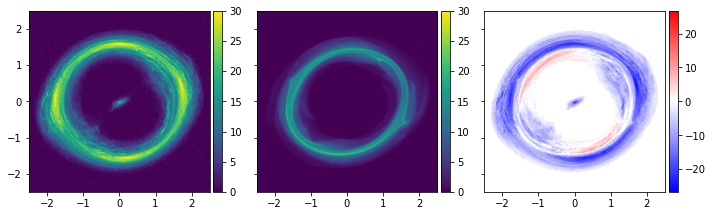

In [27]:
plot_fit_resids()

##### Parameters

gamma_1: +0.11404±0.00905 (0.007+0.107035: 11.8-sigma)
gamma_2: +0.04135±0.02815 (0.01+0.031347: 1.1-sigma)
    phi: +0.45968±0.03087 (1.0-0.540318: 17.5-sigma)
      q: +0.53967±0.01838 (0.75-0.210328: 11.4-sigma)
  r_ein: +1.45339±0.05147 (1.5-0.046612: 0.9-sigma)
      x: +0.00417±0.01401 (-0.05+0.054167: 3.9-sigma)
      y: +0.00714±0.01335 (0.1-0.092856: 7.0-sigma)



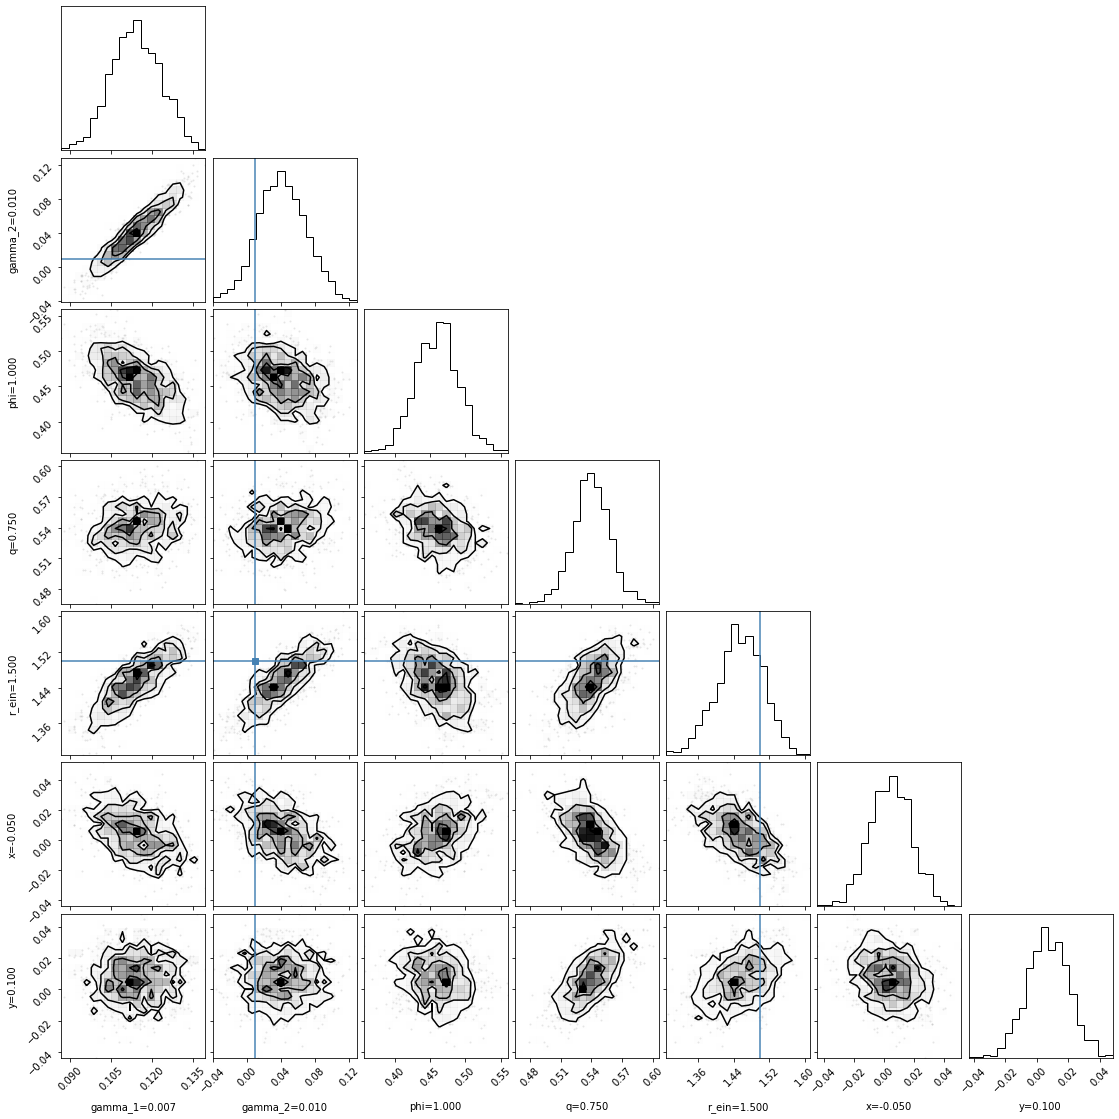

In [28]:
display_guide(PARAMS['truth'], guide.g, exclude=lambda name: name.startswith('src') or name.startswith('gp'))
print()

##### Source plane

In [29]:
#plot_source(gp)

In [30]:
from skimage.transform import resize
from more_itertools import always_iterable
from itertools import chain


src_true = 30 * np.load(os.path.join('../../mock_data/sources', f'{SYSTEM_NAME}.npy'))

scale = PARAMS['scale']
SRCRES = src_true.shape[0]
srcimkwargs = dict(extent=2*(-scale/2, scale/2), origin='lower')

src_true = resize(src_true, (SRCRES, SRCRES))
psrc = torch.stack(get_meshgrid(scale / SRCRES, SRCRES, SRCRES), -1).reshape(-1, 2)

`psrc` is a reshaped version of the pixel grid `(Xsrc, Ysrc)` of the real image. It's stacking and reshaping the grid.

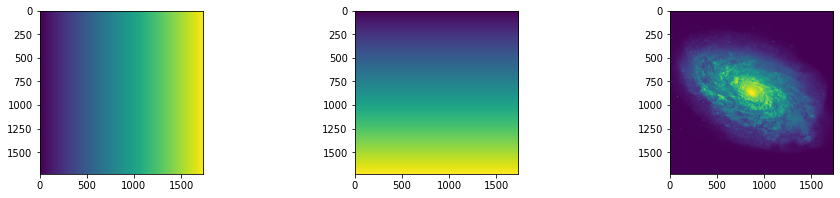

In [52]:
plots = [get_meshgrid(scale / SRCRES, SRCRES, SRCRES)[0], get_meshgrid(scale / SRCRES, SRCRES, SRCRES)[1], src_true]
plot_mult(plots, size_y = 3)

In [32]:
for i in [scale, SRCRES, psrc, psrc.shape]:
    print(i)
    print()

1.0

1730

tensor([[-0.4997, -0.4997],
        [-0.4991, -0.4997],
        [-0.4986, -0.4997],
        ...,
        [ 0.4986,  0.4997],
        [ 0.4991,  0.4997],
        [ 0.4997,  0.4997]])

torch.Size([2992900, 2])



In [33]:
guide_trace, model_trace = config.ppd().values()

In [34]:
Xsrc, Ysrc = model_trace.nodes['Xsrc']['value'], model_trace.nodes['Ysrc']['value']
p_all = torch.stack((Xsrc, Ysrc), -1)[..., MASK, :] # psrc version of the fitted source 

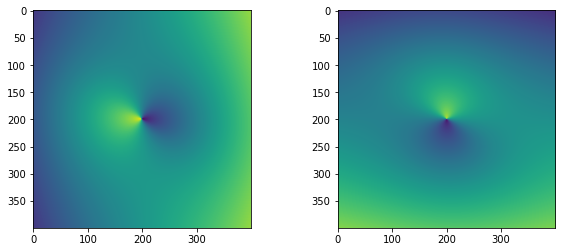

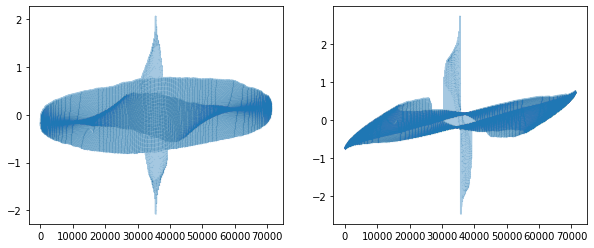

In [35]:
plot_mult([Xsrc, Ysrc], size_x = 10, size_y = 4)

fig, axs = plt.subplots(1, 2, figsize = (10, 4))
for ax, i in zip(axs.flatten(), range(2)):
    ax.plot(p_all.T[i], marker = '.', markersize = 0.2, alpha = 0.4)
plt.show()

In [36]:
sigmas = tuple(chain(*(always_iterable(config.kwargs['defs'][key].sigma) for key in model.sources.keys())))
srcimgs = tuple(chain(*(
    src.flux(psrc).reshape(-1, SRCRES, SRCRES) # What is flux? How does it work? sources/gp/bases
    for src in model.sources.values()
)))
srcimg = sum(srcimgs).squeeze()

In [37]:
# Clarification sigmas
for key in model.sources.keys():
    print(key, '\t', config.kwargs['defs'][key].sigma)
print()
print(sigmas)

src 	 tensor(0.0400)
gp 	 tensor([0.0100, 0.0045, 0.0020])

(tensor(0.0400), tensor(0.0100), tensor(0.0045), tensor(0.0020))


In [38]:
# Clarification srcimgs
for src in model.sources.values():
    print(src)
    print(src.flux(psrc))
    print(src.flux(psrc).reshape(-1, SRCRES, SRCRES).shape)
#     print(src.flux(psrc).reshape(-1, SRCRES, SRCRES))
    print()

"src": <abc.StochasticWrapper<UnitPriorGPSource> object at 0x14d7530dcd00>
tensor([0.5158, 0.5161, 0.5164,  ..., 0.1392, 0.1386, 0.1381])
torch.Size([1, 1730, 1730])

"gp": <abc.StochasticWrapper<UnitPriorWindowedGPSource> object at 0x14d7526ffac0>
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([3, 1730, 1730])



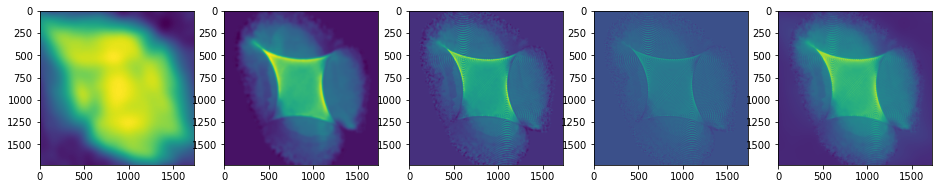

In [39]:
plots = tuple(chain(*[srcimgs, [srcimg]]))
plot_mult(plots)

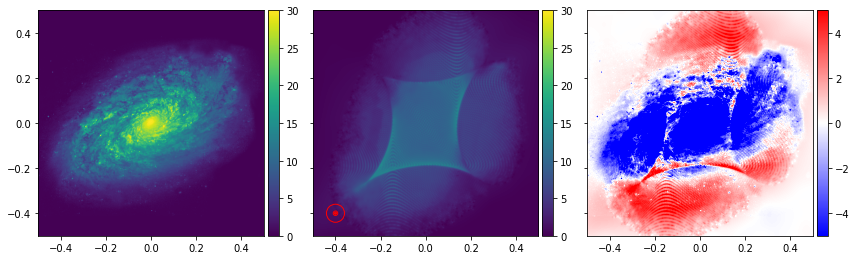

In [40]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))

# axs[0].plot(*p_all.T, 'r,')
imshow_with_cbar(ax=axs[0], img=src_true, **srcimkwargs, vmin=0, vmax=30) # true plot
imshow_with_cbar(axs[1], srcimg, **srcimkwargs, vmin=0, vmax=30) #construced total plot
imshow_with_cbar(
    axs[2], 
    srcimg-src_true, **srcimkwargs, vmin=-5, vmax=5, cmap='bwr'
) # difference

for sigma in sigmas:
    axs[1].add_artist(plt.Circle((-0.4, -0.4), radius=sigma, fill=False, ec='red', lw=1))

plt.tight_layout()

In [41]:
guide.gp_alpha()[1]

{'gp/alpha': tensor([0.5631, 0.5625, 0.5619], grad_fn=<ExpandBackward>)}

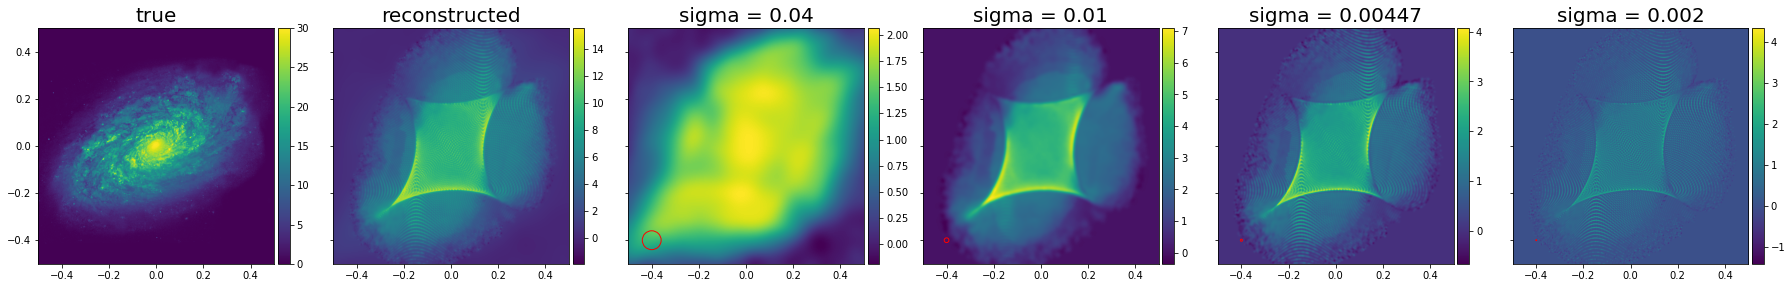

In [42]:
ncols = len(srcimgs) + 2
fig, axs = plt.subplots(1, ncols, sharex=True, sharey=True, figsize=(ncols*4+1, 4))
imshow_with_cbar(axs[0], src_true, **srcimkwargs)
imshow_with_cbar(axs[1], srcimg, **srcimkwargs)
for ax, _srcimg, sigma in zip(axs[2:], srcimgs, sigmas):
    imshow_with_cbar(ax, _srcimg, **srcimkwargs)
    ax.add_artist(plt.Circle((-0.4, -0.4), radius=sigma, fill=False, ec='red', lw=1))
plt.tight_layout()

titles = ['true', 'reconstructed'] + [f'sigma = {sigma:.{3}}' for sigma in sigmas]
for ax, title in zip(axs, titles):
    ax.set_title(title, fontsize = 20)

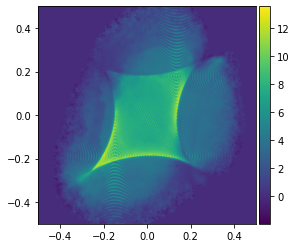

In [43]:
imshow_with_cbar(plt.gca(), sum(srcimgs[1:]), **srcimkwargs)